In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.backends.cudnn import benchmark
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
directories = [0, 1, 2, 3]

device = torch.device('cuda:0')
dtype = torch.float32
benchmark = True

def read_all_image_folders(directories):
    images_150, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 1))        
                images_150.append(scale_image(image, 0.5))
    return images_150, images_300

In [3]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [4]:
data_150, data_300 = read_all_image_folders(directories)

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
x = torch.tensor(data_150, device = device, dtype = dtype)
y = torch.tensor(data_300, device = device, dtype = dtype)

In [6]:
learning_rate = 0.001
batch_size = 32
epochs = 601

weight_decay = 0.001

In [7]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 11, stride = 1, padding = 5),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [8]:
model = generator().cuda()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCELoss()

In [10]:
# Train
loss_hist = []
psnr_hist = []
mse_hist = []
start = time.time()

for t in range(epochs):
    for batch in range(0, int(x.shape[0]/batch_size)):
            
        batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
        outputs = model.forward(batch_x)

        loss = criterion(outputs, batch_y)
        mse = F.mse_loss(outputs, batch_y)
        psnr = 10 * math.log10(1 / mse)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if t % 5 == 0:
        loss_hist.append(loss.item())
        psnr_hist.append(psnr)
        mse_hist.append(mse)
        print(t, f"PSNR: {psnr}, BCE: {loss.item()}, MSE: {mse}, Time (m): {(time.time() - start) / 60}")
print('----------')
print(f'Full Time (m): {(time.time() - start) / 60}')

0 PSNR: 23.256886086525466, BCE: 0.5288689732551575, MSE: 0.004724016413092613, Time (m): 0.6364835778872172
5 PSNR: 23.808676277678117, BCE: 0.5266854166984558, MSE: 0.004160373937338591, Time (m): 3.8241820255915324
10 PSNR: 25.607023174979417, BCE: 0.5234634876251221, MSE: 0.0027497783303260803, Time (m): 7.013009627660115
15 PSNR: 25.26022297765717, BCE: 0.5238960385322571, MSE: 0.0029783635400235653, Time (m): 10.199514750639597
20 PSNR: 24.823601385806114, BCE: 0.524503767490387, MSE: 0.0032933650072664022, Time (m): 13.384655932585398
25 PSNR: 25.561994048531396, BCE: 0.5230719447135925, MSE: 0.0027784372214227915, Time (m): 16.569849940141044
30 PSNR: 25.884002222463785, BCE: 0.5225066542625427, MSE: 0.002579881576821208, Time (m): 19.75492043097814
35 PSNR: 26.22772277033295, BCE: 0.5223230719566345, MSE: 0.002383569022640586, Time (m): 22.940088069438936
40 PSNR: 25.706089891700266, BCE: 0.5228840112686157, MSE: 0.002687763189896941, Time (m): 26.125249123573305
45 PSNR: 25.7

RuntimeError: CUDA out of memory. Tried to allocate 175.88 MiB (GPU 0; 10.91 GiB total capacity; 9.04 GiB already allocated; 175.12 MiB free; 241.62 MiB cached)

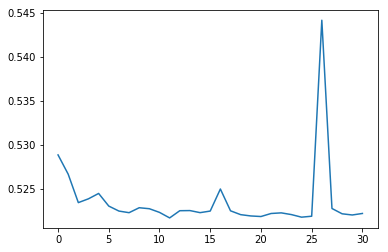

In [11]:
#exp 408
plt.plot(loss_hist)

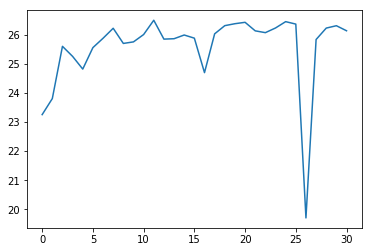

In [12]:
plt.plot(psnr_hist)

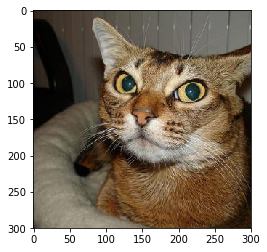

In [13]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

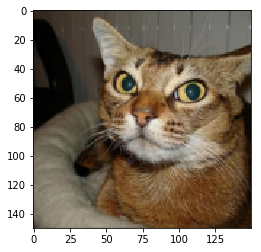

In [14]:
image_down = rescale(image=image, scale=0.5, multichannel=True, anti_aliasing=True).reshape(1, 150, 150, 3)
plt.imshow(image_down.reshape(150,150,3))
plt.show()

In [15]:
image_up = model.forward(torch.tensor(image_down, dtype = dtype, device = device).transpose(1, 3))

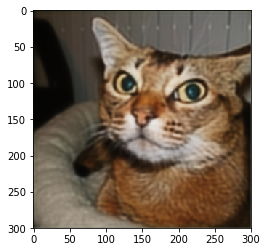

In [16]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(300, 300, 3))
plt.show()

In [17]:
torch.save(model.cpu(), f'../data/models/x2_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
